## Model Creation

Let's create a model first, with some vocab.
The output is a dataset.

In [20]:
%pip install librosa numpy soundfile torch torchaudio datasets transformers matplotlib

515.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [21]:
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import WavLMModel, AutoFeatureExtractor
import datasets
import numpy as np

# ————————————————————————————————————————————————————————————————————————
# PhonemeRecognizer: WavLM + CTC for phoneme speech recognition
# ————————————————————————————————————————————————————————————————————————

# Load vocab from file
with open("phoneme_tokenizer/vocab.json") as vocab_file:
    vocab = json.load(vocab_file)

# IT + FR phonemes + blank
VOCAB = {
  "0": "ʒ",
  "1": "ɹ",
  "2": "j",
  "3": "d",
  "4": "ɲ",
  "5": "ʌ",
  "6": "[UNK]",
  "7": "ɒ",
  "8": "ɐ",
  "9": "ʃ",
  "10": "ɔ",
  "11": "f",
  "12": "ø",
  "13": "z",
  "14": "ŋ",
  "15": "i",
  "16": "u",
  "17": "̃",
  "18": "o",
  "19": "œ",
  "20": "a",
  "21": "(",
  "22": "ə",
  "23": "ɜ",
  "24": "ɾ",
  "25": "ː",
  "26": "̪",
  "27": "e",
  "28": "b",
  "29": "ʁ",
  "30": "w",
  "31": "n",
  "32": "p",
  "33": "y",
  "34": "ɡ",
  "35": "ɪ",
  "36": "r",
  "37": "v",
  "38": "t",
  "39": ")",
  "40": "m",
  "41": "k",
  "42": "ʊ",
  "43": "ʎ",
  "44": "ɑ",
  "45": "s",
  "46": "l",
  "47": "[PAD]",
  "48": "ɛ",
  "49": '<blank>' # blank token for CTC
}
PHONEME_DICT = {v: int(k) for k, v in VOCAB.items()}

NUM_PHONEMES = len(PHONEME_DICT)

class PhonemeRecognizer(nn.Module):
    def __init__(self, wavlm_model, num_phonemes=NUM_PHONEMES):
        super().__init__()
        self.wavlm = wavlm_model

        # Get the hidden size from the WavLM model
        hidden_size = self.wavlm.config.hidden_size

        # Add a dropout layer for regularization
        self.dropout = nn.Dropout(0.1)

        # Linear layer to map from WavLM hidden states to phoneme classes (including blank)
        self.phoneme_classifier = nn.Linear(hidden_size, num_phonemes)

    def forward(self, inputs):
        # Get WavLM embeddings
        outputs = self.wavlm(**inputs)
        hidden_states = outputs.last_hidden_state

        # Apply dropout
        hidden_states = self.dropout(hidden_states)

        # Apply the linear layer to get logits for each time step
        logits = self.phoneme_classifier(hidden_states)

        # Apply log softmax for CTC loss
        log_probs = F.log_softmax(logits, dim=-1)

        return log_probs
    
    def classify_to_phonemes(self, log_probs):
        # Simple greedy decoding (for demonstration)
        # In a real system, you would use beam search with ctcdecode
        predictions = torch.argmax(log_probs, dim=-1).cpu().numpy()

        # Convert to phoneme sequences with CTC decoding rules (merge repeats, remove blanks)
        phoneme_sequences = []
        for pred_seq in predictions:
            seq = []
            prev = -1
            for p in pred_seq:
                # Skip blanks (index 0) and repeated phonemes (CTC rules)
                if p != 0 and p != prev:
                    # Convert index back to phoneme
                    phoneme = list(PHONEME_DICT.keys())[list(PHONEME_DICT.values()).index(p)]
                    seq.append(phoneme)
                prev = p
            phoneme_sequences.append(seq)

        return phoneme_sequences


    def recognize(self, inputs, beam_width=100):
        """Perform phoneme recognition without beam search decoding"""
        self.eval()
        with torch.no_grad():
            # Forward pass to get log probabilities
            log_probs = self(inputs)

            return self.classify_to_phonemes(log_probs)

    def tokenize(self, char_list):
        """Go from a list of characters to a list of indices."""
        return torch.tensor([PHONEME_DICT[x] for x in char_list])
    
    def get_embedding(self, char_list):
        tokens = self.tokenize(char_list)
        out_tensor = torch.zeros((len(tokens), len(PHONEME_DICT)))
        for i, token_id in enumerate(tokens):
            out_tensor[i, token_id] = 1
        return out_tensor

# ————————————————————————————————————————————————————————————————————————
# Method A: Using the PhonemeRecognizer for speech-to-phoneme ASR
# ————————————————————————————————————————————————————————————————————————

# 1. Load the feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")
wavlm_model = WavLMModel.from_pretrained("microsoft/wavlm-base-plus")

# Create the phoneme recognizer with the WavLM model
phoneme_recognizer = PhonemeRecognizer(wavlm_model)
phoneme_recognizer.eval()  # disable dropout, etc.

# 2. Load an example audio file (here using a small demo from `datasets`)
#    The `audio["array"]` is a NumPy array of floats; sampling_rate is an int.
ds = datasets.load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
audio_sample = ds[0]["audio"]["array"]
sr = ds[0]["audio"]["sampling_rate"]

def get_audio_features(batch):
    # 3. Preprocess (pad/truncate + batch‐dim)
    for data_row in batch:
        if data_row["sampling_rate"] != 16000:
            raise NotImplementedError(
                f"No sampling rate can be different from 16000, is {data_row["sampling_rate"]}"
            )

    inputs = feature_extractor(
        [data_row["array"] for data_row in batch],
        sampling_rate=16000,
        return_tensors="pt",        # => PyTorch tensors
        padding=True,               # pad to longest in batch
    )
    return inputs


def run_inference(batch, model):
    """Return log probs and most likely phonemes."""
    inputs = get_audio_features(batch["audio"])

    # 4. Inference for phoneme recognition
    with torch.no_grad():
        # Get phoneme log probabilities
        log_probs = model(inputs)

        # Recognize phoneme sequence
        phoneme_sequences = model.recognize(inputs)

    return {"log_probs": log_probs, "phonemes": phoneme_sequences}

predicted = ds.select(range(2)).map(
    lambda data_row: run_inference(data_row, phoneme_recognizer),
    batched=True
)

# Print output
print("Log probabilities shape:", np.shape(predicted["log_probs"]))  # (batch_size, seq_len, num_phonemes)
print("Recognized phoneme sequence:", "".join(predicted["phonemes"][0]))
print("Transcript for reference:", ds[0]["text"])

Map:   0%|          | 0/2 [00:00<?, ? examples/s]/home/hugo/Documents/dev/asr/Lemanic-Life-Sciences-Hackathon-2025/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Map: 100%|██████████| 2/2 [00:00<00:00,  3.20 examples/s]

Log probabilities shape: (2, 292, 50)
Recognized phoneme sequence: noɛnəmœɑdby<blank>ɑmlɹzdfɒz[UNK]jɑʁoɹʃɛlytɒploləzd[PAD]t[UNK]̃[PAD]r[PAD]əfɐɹɜzerɛzɛtyozl[PAD]v<blank>[PAD]ɐldɛzd[UNK]ʁ<blank>ɛ[PAD]ɲɒɐʌɔl)søsɜy)zis[PAD]njbpdoɲ[UNK]jl<blank>lpɛɐtbdsfjrt[UNK]lɜz)jlɐnjo)(ə(dɛɲz(ʁɑl[PAD]ʃifɐɹɛ[PAD]zibzryɛd)ɡodɹ[PAD]ɹ̃[PAD]ɐɑə
Transcript for reference: MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL


## Dataset

Let's load our data in a Hugging Face dataset.

In [16]:
import os

import datasets

# 1. Location of your CSV
language = ("fr", "it")[0]
audio_files_path = "Hackathon_ASR/2_Audiofiles/" + {
    "fr": "Phoneme_Deletion_FR",
    "it": "Decoding_IT"
}[language] + "_T1/"
dataset_path = f"datasets/phonemized_{language}.csv"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"{dataset_path} does not exist and should be regenerated!")


# 2. Define initial features: audio paths as plain strings, phonemes as plain strings
features = datasets.Features({
    "file_name": datasets.Value("string"),
    "phonemes_coder1": datasets.Value("string"),
    "phonemes_coder2": datasets.Value("string")
})

# 3. Load the CSV into a DatasetDict (default split is 'train')
dataset = datasets.load_dataset("csv", data_files=dataset_path, features=features, split="train")

# 4. Rename the audio-path column to 'audio' (required by Audio feature)
dataset = dataset.map(lambda data_row: {"audio": audio_files_path + data_row["file_name"]})

# 5. Cast 'audio' to the Audio type (will load the file when you access it)
dataset = dataset.cast_column("audio", datasets.Audio(sampling_rate=16_000))

# 6. Map + split phoneme strings into lists
def split_in_bracket(string):
    output = []
    in_brackets = False
    if string is None:
        return output
    for char in string:
        if in_brackets:
            output[-1] += char
        else:
            output.append(char)

        if char == '[':
            in_brackets = True
        elif char == ']':
            in_brackets = False
    return output

def split_phonemes(data_row):
    """Split each phoneme into a list."""
    data_row["target_phonemes1"] = split_in_bracket(data_row["phonemes_coder1"])
    data_row["target_phonemes2"] = split_in_bracket(data_row["phonemes_coder2"])
    return data_row


dataset = dataset.map(split_phonemes, remove_columns=["phonemes_coder1", "phonemes_coder2"])

# 7. Cast the phoneme_sequence column to a Sequence of strings
dataset = dataset.cast_column(
    "target_phonemes1",
    datasets.Sequence(feature=datasets.Value("string"))
).cast_column(
    "target_phonemes2",
    datasets.Sequence(feature=datasets.Value("string"))
)

# Now 'dataset' has:
#   - dataset[i]["audio"] → { "array": np.ndarray, "sampling_rate": 16000 }
#   - dataset[i]["target_phonemes1"] → list of strings
print(dataset)
print(dataset[0]["audio"])
print(dataset[0]["target_phonemes1"])


Map:   0%|          | 0/5507 [00:00<?, ? examples/s]

Map:   0%|          | 0/5507 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5507 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5507 [00:00<?, ? examples/s]

Dataset({
    features: ['file_name', 'audio', 'target_phonemes1', 'target_phonemes2'],
    num_rows: 5507
})
{'path': 'Hackathon_ASR/2_Audiofiles/Phoneme_Deletion_FR_T1/3101_edugame2023_1c148def3c254026adc7a7fdc3edc6f6_2249c5f2f75d4b089bee1f36e1a7aef2.wav', 'array': array([1.97946756e-05, 3.31596239e-05, 2.90264506e-05, ...,
       1.05573982e-03, 2.05589482e-03, 0.00000000e+00], shape=(66317,)), 'sampling_rate': 16000}
['ɑ', '̃', '[PAD]', 'n', 'a', 'ʒ']


## Putting stuff together

Now we run the model on our in-house dataset.
We will extract the features so that it is easier to work with latter on.
For this version we don't train the model, only a fine-tuning.

In [ ]:
import os

DATASETS_DIR = "datasets"
dataset_path = f"{DATASETS_DIR}/features"

if os.path.exists(dataset_path):
    features_dataset = datasets.load_from_disk(dataset_path)
else:
    wavlm_model.eval()

    with torch.no_grad():
        features_dataset = dataset.map(
            lambda batch: {
                "features": wavlm_model(**get_audio_features(batch["audio"])).last_hidden_state
            },
            batched=True,
            remove_columns=["audio"],
            batch_size=15
        )

    features_dataset.save_to_disk(dataset_path)
features_dataset


Dataset({
    features: ['target_phonemes', 'features'],
    num_rows: 932
})

## Defining a new linear layer

As a speed-up, we simply create a linear layer to map from the extracted features to the phonemes.

In [26]:
class PhonemeMapper(nn.Module):
    def __init__(self, features_size, num_phonemes=NUM_PHONEMES):
        super().__init__()

        # Add a dropout layer for regularization
        self.dropout = nn.Dropout(0.1)

        # Linear layer to map from WavLM hidden states to phoneme classes (including blank)
        self.phoneme_classifier = nn.Linear(features_size, num_phonemes)

    def forward(self, inputs):
        # Apply dropout
        hidden_states = self.dropout(inputs)

        # Apply the linear layer to get logits for each time step
        logits = self.phoneme_classifier(hidden_states)

        # Apply log softmax for CTC loss
        log_probs = F.log_softmax(logits, dim=-1)

        return log_probs
    
    def classify_to_phonemes(self, log_probs):
        # Simple greedy decoding (for demonstration)
        # In a real system, you would use beam search with ctcdecode
        predictions = torch.argmax(log_probs, dim=-1).cpu().numpy()

        # Convert to phoneme sequences with CTC decoding rules (merge repeats, remove blanks)
        phoneme_sequences = []
        for pred_seq in predictions:
            seq = []
            prev = -1
            for p in pred_seq:
                # Skip blanks (index 0) and repeated phonemes (CTC rules)
                if p != 0 and p != prev:
                    # Convert index back to phoneme
                    phoneme = list(PHONEME_DICT.keys())[list(PHONEME_DICT.values()).index(p)]
                    seq.append(phoneme)
                prev = p
            phoneme_sequences.append(seq)

        return phoneme_sequences
    
linear_mapper = PhonemeMapper(wavlm_model.config.hidden_size, NUM_PHONEMES)

wavlm_model.config.hidden_size, NUM_PHONEMES

(768, 50)

## Model fine-tuning

Now that the linear layer is ready, we can simply train it.

In [ ]:
import csv
import os
import re
import warnings

linear_mapper.train()
linear_optimizer = torch.optim.Adam(linear_mapper.parameters(), lr=1e-5, weight_decay=0)

batch_size = 8

def calculate_ctc_loss(log_probs, target_sequence):
    """Calculates CTC loss."""
    # Create input_lengths and target_lengths tensors
    input_lengths = torch.tensor([batch_size])  # Batch size of 1
    target_lengths = torch.tensor([batch_size])  # Batch size of 1

    # Calculate CTC loss
    loss = F.ctc_loss(
        log_probs,
        target_sequence,
        input_lengths=input_lengths,
        target_lengths=target_lengths
    )
    return loss

MODEL_DIR = "models"
OUTPUTS_DIR = "outputs"

def prepare_folders():
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    if not os.path.exists(OUTPUTS_DIR):
        os.makedirs(OUTPUTS_DIR)
    

def load_last_checkpoint(model_dir):
    increment = -1
    name_format = r"linear_mapper_.*(\d+)\.pth$"
    # Load the latest version
    pth_files = [f for f in os.listdir(model_dir) if re.search(name_format, f)]
    increment = len(pth_files)

    if not pth_files:
        warnings.warn("No .pth files found in the model directory! Starting from scratch!")
    else:
        # Sort the files by their index (last number)
        pth_files.sort(key=lambda x: int(re.search(name_format, x)[1]))

        # Load the latest version
        checkpoint = pth_files[-1]  # Load the last element (highest index)
        match = re.search(name_format, checkpoint)
        if match:
            increment = int(match[1])
            # Load the linear layer's parameters
            linear_mapper.load_state_dict(
                torch.load(f"{model_dir}/{checkpoint}")
            )
        else:
            warnings.warn("Couldn't find a model! Starting from scratch!")
    return increment

prepare_folders()
increment = load_last_checkpoint(MODEL_DIR)


def write_to_csv(row):
    with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(row)

# Training loop
for epoch in range(10):
    for i in range(0, len(features_dataset), batch_size):
        batch_data = features_dataset.shuffle()[i:i + batch_size]


        input_lengths = torch.zeros(batch_size, dtype=torch.uint32)
        max_len = max(map(len, batch_data["features"]))

        input_batch = torch.zeros((batch_size, max_len, wavlm_model.config.hidden_size))
        for i, feat in enumerate(batch_data["features"]):
            input_batch[i, :len(feat)] = torch.tensor(feat)
            input_lengths[i] = len(feat)

        log_probs = linear_mapper(
            input_batch.reshape(
                (batch_size, -1, wavlm_model.config.hidden_size)
            )
        )
        targets = [phoneme_recognizer.tokenize(string) for string in batch_data["target_phonemes"]]
        target_lengths = torch.zeros(batch_size, dtype=torch.uint8)
        max_len = max(map(lambda x: x.shape[0], targets))

        target_batch = torch.zeros((batch_size, max_len))
        for i, target in enumerate(targets):
            target_batch[i, :target.shape[0]] = target
            target_lengths[i] = target.shape[0]

        loss = F.ctc_loss(
            log_probs.transpose(0, 1),
            target_batch,
            input_lengths=torch.tensor([x.shape[0] for x in log_probs]),
            target_lengths=target_lengths
        )
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        for logs, target_phons in zip(phoneme_recognizer.classify_to_phonemes(log_probs), batch_data["target_phonemes"]):
            write_to_csv(
                [
                    increment, epoch, i, loss.item(), "".join(logs), "".join(target_phons)
                ]
            )
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        increment += 1
    torch.save(
        linear_mapper.state_dict(),
        f"{MODEL_DIR}/linear_mapper_epoch_{epoch}_step_{i}_{increment}.pth"
    )
    

Epoch 0, Loss: 66.48863220214844
Epoch 0, Loss: 208.7238006591797
Epoch 0, Loss: 208.34446716308594
Epoch 0, Loss: 76.80451965332031
Epoch 0, Loss: 418.4235534667969
Epoch 0, Loss: 199.16065979003906
Epoch 0, Loss: 726.5738525390625
Epoch 0, Loss: 96.77622985839844
Epoch 0, Loss: 87.0539321899414
Epoch 0, Loss: 91.49258422851562
Epoch 0, Loss: 425.8016357421875
Epoch 0, Loss: 65.01165008544922
Epoch 0, Loss: 104.83248901367188
Epoch 0, Loss: 67.78790283203125
Epoch 0, Loss: 696.1923828125
Epoch 0, Loss: 88.33753967285156
Epoch 0, Loss: 83.66516876220703
Epoch 0, Loss: 1007.812255859375
Epoch 0, Loss: 82.21784210205078
Epoch 0, Loss: 408.822265625
Epoch 0, Loss: 410.20294189453125
Epoch 0, Loss: 96.42254638671875
Epoch 0, Loss: 101.1806869506836
Epoch 0, Loss: 202.9730682373047
Epoch 0, Loss: 399.52813720703125
Epoch 0, Loss: 74.95931243896484
Epoch 0, Loss: 140.1988525390625
Epoch 0, Loss: 150.25926208496094
Epoch 0, Loss: 82.55825805664062
Epoch 0, Loss: 132.5712432861328
Epoch 0, Los

## View the results

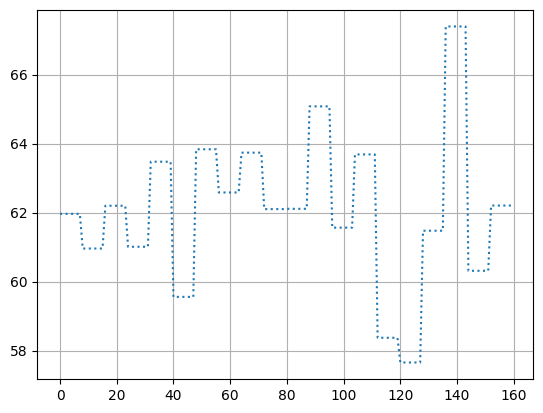

In [19]:
import matplotlib.pyplot as plt

losses = []

with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        losses.append(float(row[3]))

plt.plot(losses, label="Loss over training step", linestyle='dotted')
plt.grid()

## Model training

Now we want a phoneme recognition.
It means to train the last layer of the model to the ground truth.

In [ ]:
import csv
import os
import re

phoneme_recognizer.train()
linear_optimizer = torch.optim.Adam(
    phoneme_recognizer.phoneme_classifier.parameters(),
    lr=1e-3,
    weight_decay=0
)


def calculate_ctc_loss(log_probs, target_sequence):
    """Calculates CTC loss."""
    # Create input_lengths and target_lengths tensors
    input_lengths = torch.tensor([1])  # Batch size of 1
    target_lengths = torch.tensor([1])  # Batch size of 1

    # Calculate CTC loss
    loss = F.ctc_loss(
        log_probs,
        target_sequence,
        input_lengths=input_lengths,
        target_lengths=target_lengths
    )
    return loss

MODEL_DIR = "models"
OUTPUTS_DIR = "outputs"


def prepare_folders():
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    if not os.path.exists(OUTPUTS_DIR):
        os.makedirs(OUTPUTS_DIR)
    

def load_last_checkpoint(model_dir):
    increment = -1
    # Load the latest version
    pth_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]
    increment = len(pth_files)

    if not pth_files:
        warnings.warn("No .pth files found in the model directory! Starting from scratch!")
    else:
        # Sort the files by their index (last number)
        pth_files.sort(key=lambda x: int(re.search(r"(\d+)\.pth$", x)[1]))

        # Load the latest version
        checkpoint = pth_files[-1]  # Load the last element (highest index)
        match = re.search(r"(\d+)\.pth$", checkpoint)
        if match:
            increment = int(match[1])
            # Load the linear layer's parameters
            phoneme_recognizer.phoneme_classifier.load_state_dict(
                torch.load(f"{model_dir}/{checkpoint}")
            )
        else:
            warnings.warn("Couldn't find a model! Starting from scratch!")
    return increment

prepare_folders()
increment = load_last_checkpoint(MODEL_DIR)

# Freeze the wavlm model
for param in phoneme_recognizer.wavlm.parameters():
    param.requires_grad = False


def write_to_csv(row):
    with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(row)


# Training loop
for epoch in range(10):
    for i, data in enumerate(dataset.shuffle().select(range(50))):
        inputs = get_audio_features(data)
        log_probs = phoneme_recognizer(inputs)
        split_phonemes = smart_split_coder(data["phoneme_sequence"][0])
        target = phoneme_recognizer.tokenize(split_phonemes)
        loss = calculate_ctc_loss(log_probs[0], target.reshape([1, -1]))
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        write_to_csv(
            [
                increment, epoch, i, loss.item(),
                "".join(phoneme_recognizer.classify_to_phonemes(log_probs)[0]),
                "".join(split_phonemes)
            ]
        )
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        increment += 1
        torch.save(
            phoneme_recognizer.phoneme_classifier.state_dict(),
            f"{MODEL_DIR}/phoneme_classifier_epoch_{epoch}_step_{i}_{increment}.pth"
        )
    

Epoch 0, Loss: 2.4194483757019043


/home/hugo/Documents/dev/asr/Lemanic-Life-Sciences-Hackathon-2025/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 0, Loss: 3.888230800628662
Epoch 0, Loss: 1.146170735359192
Epoch 0, Loss: 6.249912738800049
Epoch 0, Loss: 1.2091354131698608
Epoch 0, Loss: 3.8059654235839844
Epoch 0, Loss: 2.063833713531494


## Binary classification

We have a model roughly trained for phonemes.
We want a binary classification though.
We won't do that for now as it would be an end-to-end pipeline, defeating the purpose of the created pipeline.